<a href="https://colab.research.google.com/github/UPstartDeveloper/DS-2.4-Advanced-Topics/blob/main/Notebooks/IntroToMLDL/CIFAR10_DNN_ZR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification in Deep Neural Networks

We will be using the CIFAR10 dataset.

## Import Packages

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
# every chapter has its own images?
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    '''This function will save our Matplotlib figures as image files.'''
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
print(tf.__version__)

2.4.1


In [4]:
print(keras.__version__)

2.4.0


## Load the Data

*About CIFAR-10*:

*   60,000 32x32 color images total 
*   50,000 training images + 10,000 test images
*   10 classes
*   **Balanced**: 6000 images per class.
*   [Source](https://www.cs.toronto.edu/~kriz/cifar.html)

Let's get the data from Keras, and verify the above is true.



In [5]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 7s 0us/step


In [6]:
# Dimensions of Training Data
X_train_full.shape

(50000, 32, 32, 3)

In [7]:
# Dimensions of the Test Data
X_test.shape

(10000, 32, 32, 3)

In [8]:
# Number of Classes
np.unique(y_train_full)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### Verifying the Dataset is Balanced

In [13]:
# Numpy.unique helps us create a frequency distribution: https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray
train_classes, class_counts = np.unique(y_train_full, return_counts=True)
class_dist_in_training = dict(zip(train_classes, class_counts))
class_dist_in_training

{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

In [14]:
# Do the Same for the Test Data
test_classes, class_counts = np.unique(y_test, return_counts=True)
class_dist_in_test = dict(zip(test_classes, class_counts))
class_dist_in_test

{0: 1000,
 1: 1000,
 2: 1000,
 3: 1000,
 4: 1000,
 5: 1000,
 6: 1000,
 7: 1000,
 8: 1000,
 9: 1000}

## Split the Data

In [9]:
# What Range are the Pixel Values in?
X_train_full.dtype

dtype('uint8')

Based on the output of the above cell, we'll want to **normalize the input** images so their pixel intensity stays between 0-1.

At the same time, we'll split off about 20% of the training data to use for validation:

In [28]:
X_valid, X_train = X_train_full[40_000:] / 255., X_train_full[:40_000] / 255.
y_valid, y_train = y_train_full[40_000:], y_train_full[:40_000]
X_test = X_test / 255.

## Explore the Data

Saving figure cifar10_plot


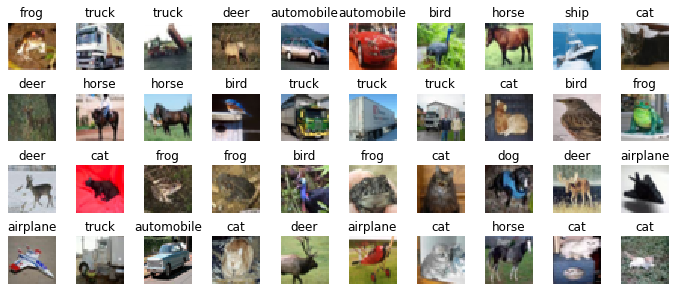

In [24]:
def plot_example_images(n_rows, n_cols, 
                        X_train, y_train, 
                        class_names,
                        figure_name="cifar10_plot"):
  """Plots several examples of images in the dataset.

  We plot a grid of n_rows x n_cols, using example images from
  the training data. We will also save the plot, using the given name.

  Args:
    n_rows: int
    n_cols: int
    X_train: array-like object containing the images
    y_train: array-like object containing the labels (as sparse integers)
    class_names: array-like object containing the labels (as strings)
  
  Keyword Args:
    figure_name: str. Tells Matplotlib what to name the saved figure.

  Returns: None
  """
  plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
  for row in range(n_rows):
      for col in range(n_cols):
          index = n_cols * row + col
          plt.subplot(n_rows, n_cols, index + 1)
          plt.imshow(X_train[index], interpolation="nearest")
          plt.axis('off')
          class_index = int(y_train[index])
          plt.title(class_names[class_index], fontsize=12)
  plt.subplots_adjust(wspace=0.2, hspace=0.5)
  save_fig(figure_name, tight_layout=False)
  plt.show()
  return None

# make the plot 
class_names = [
  "airplane", "automobile", "bird", "cat", "deer",
  "dog", "frog", "horse", "ship", "truck"
]
n_rows = 4
n_cols = 10
plot_example_images(
    n_rows, n_cols, 
    np.array(X_train_full), 
    np.array(y_train_full),  
    class_names
)

## Build the Model

We'll bbuild this based on the spec in exercise #8 from Ch. 11 of Aurélien Géron's *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition* (2019):

- 20 hidden layers 
- 100 neurons each 
- He initialization and the ELU activation function

In [34]:
from functools import partial

# make a wrapper around Keras' Dense layer, to make code more DRY
Dense = partial(keras.layers.Dense,
                activation="elu",
                kernel_initializer="he_normal")

def manufacture_dense_layers(layers, neurons):
  """Make as many Dense layers as specified.

  Args:
    layers: int. The number of dense layers we'll instantiate.
    neurons: int. The number of neurons in each dense layer.

  Returns: a fully connected sequential neural network, implemented in 
           Keras' Sequential API
  """
  return keras.models.Sequential([
    Dense(neurons) for _ in range(layers)
  ])

# build the full model
IMAGE_WIDTH, IMAGE_HEIGHT = X_train.shape[1], X_train.shape[2] 
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[IMAGE_WIDTH, IMAGE_HEIGHT]),
    manufacture_dense_layers(20, 100),
    # we'll be doing sparse categorical classification
    Dense(10, activation="softmax",
          # remember that Glorot initialization must be used 
          # when softmax is the activation function
          kernel_initializer="glorot_uniform")
])